# ***Clasificarea melodiilor in functie de genurile muzicale folosind CMMP***

Rezolvarea de sisteme de ecuații liniare în sens CMMP reprezintă una dintre cele mai simple metode de a creea un clasificator binar.
Pentru cazul în care dorim totuși să facem o multiclasificare, se poate extrapola acest algoritm. Ideea este că se fac mai multe comparații de tip 1 la restul: Este obciectul verificat inclus în prima categorie sau este în restul? Este obciectul verificat inclus în a doua categorie sau este în restul? ...
Vom aplica acum principiul pentru clasificarea melodiilor după genul muzical:

Pentru început, includem aceste biblioteci:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tkinter import filedialog
import IPython

Pentru antrenarea modelului, vom folosi baza de date GTZAN, care reprezintă o selecție de 1000 de fragmente audio (câte 100 pentru fiecare gen muzical), fiecare având 30 de secunde. În etapa de preprocesare, am creat un dataframe din spectogramele tuturor acestor fragmente, pe care l-am salvat într-un fișier .csv. Acum încărcăm acest .csv:

In [2]:
df = pd.read_csv('./genre_mel_specs.csv')
n, m = df.shape
df[df.columns[m-1]].nunique()

10

Acum, având datele de antrenament, putem creea sistemul liniar. O să eliminăm coloana cu etichetele din dataframe-ul importat mai sus și o să adăugăm o coloană plină cu 1, obținând astfel matricea de proprietăți. Coloana de etichete este păstrată într-o variabilă separată, pentru că va fi folosită pentru creearea unei noi coloane de etichete, folosită pentru comparația cu fiecare gen muzical mai departe:

In [3]:
features = df.drop(df.columns[m-1], axis=1)
label_original = df[df.columns[m-1]]
A = np.append(features,np.ones((n,1)),axis=1)
n,m = features.shape

Funcția aceasta este folosită pentru a creea o spectogramă a melodiei alese de către utilizator și pentru a o stoca apoi într-un dataframe:

In [4]:
def wav_to_df(file):
    y, sr = librosa.core.load(file)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    if spect.shape[1] != 660: spect.resize(128,660, refcheck=False)
    spect = spect.flatten()
    spect = np.array(spect)
    df_t = pd.DataFrame(spect)
    
    return df_t

Acum se deschide o fereastră de dialog, astfel încât utilizatorul să-și aleagă fișierul .wav:

In [5]:
file_path = filedialog.askopenfilename()
df_t = wav_to_df(file_path)

Să "vizualizăm" ce a selectat utilizatorul:
- Fragmentul audio:

In [6]:
y, sr = librosa.core.load(file_path)
IPython.display.Audio(y, rate=sr)

- Spectograma:

(1025, 1292)

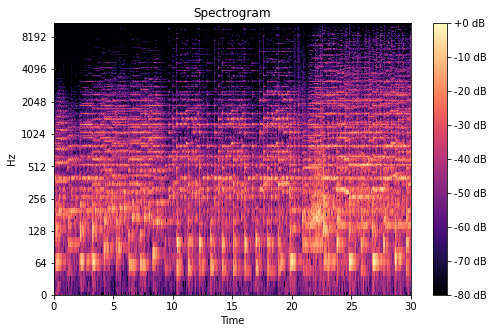

In [7]:
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
plt.figure(figsize=(8,5));
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');
spec.shape

Acum dataframe-ul de testare se transformă într-o matrice numpy și încep calculele.<br>
Pentru fiecare gen în parte, avem câte un sistem de ecuații liniare care trebuie rezolvat. Motivul pentru care diferă de la gen la gen acest sistem este coloana <i>label</i>, care de fiecare dată se modifică în felul următor: pentru genul care se verifică fișierul audio, eticheta este 1, iar pentru restul este -1. Acest fapt este cauzat de faptul că Algoritmul bazat pe CMMP nu a fost conceput pentru un multiclasificator, ci pentru un clasificator binar. În cazul nostru așadar, facem 10 comparații binare (de aceea și timpul de rulare este, din păcate, mai mare):

In [107]:
testFeatures =df_t.to_numpy() 

label_dict = {'jazz': 1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': -1,'country': -1,'metal': -1,'classical': -1,'disco': -1,'pop': -1}
label = label_original.map(label_dict)
clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
print(test_label)

if (test_label >= 0): print('Jazz')
else:
    label_dict = {'jazz': -1,'reggae': 1,'rock': -1,'blues': -1,'hiphop': -1,'country': -1,'metal': -1,'classical': -1,'disco': -1,'pop': -1}
    label = label_original.map(label_dict)
    clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
    test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
    print(test_label)
    
    if (test_label >= 0): print('Reggae')
    else:
        label_dict = {'jazz': -1,'reggae': -1,'rock': 1,'blues': -1,'hiphop': -1,'country': -1,'metal': -1,'classical': -1,'disco': -1,'pop': -1}
        label = label_original.map(label_dict)
        clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
        test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
        print(test_label)
    
        if (test_label >= 0): print('Rock')
        else:
           label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': 1,'hiphop': -1,'country': -1,'metal': -1,'classical': -1,'disco': -1,'pop': -1}
           label = label_original.map(label_dict)
           clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
           test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
           print(test_label)
           
           if (test_label >= 0): print('Blues')
           else:
               label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': 1,'country': -1,'metal': -1,'classical': -1,'disco': -1,'pop': -1}
               label = label_original.map(label_dict)
               clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
               test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
               print(test_label)
               
               if (test_label >= 0): print('HipHop')
               else:
                   label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': -1,'country': 1,'metal': -1,'classical': -1,'disco': -1,'pop': -1}
                   label = label_original.map(label_dict)
                   clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
                   test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
                   print(test_label)
                   
                   if (test_label >= 0): print('Country')
                   else:
                       label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': -1,'country': -1,'metal': 1,'classical': -1,'disco': -1,'pop': -1}
                       label = label_original.map(label_dict)
                       clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
                       test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
                       print(test_label)
                       
                       if (test_label >= 0): print('Metal')
                       else:
                           label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': -1,'country': -1,'metal': -1,'classical': 1,'disco': -1,'pop': -1}
                           label = label_original.map(label_dict)
                           clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
                           test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
                           print(test_label)
                           
                           if (test_label >= 0): print('Clasic')
                           else:
                               label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': -1,'country': -1,'metal': -1,'classical': -1,'disco': 1,'pop': -1}
                               label = label_original.map(label_dict)
                               clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
                               test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
                               print(test_label)
                               
                               if (test_label >= 0): print('Disco')
                               else:
                                   label_dict = {'jazz': -1,'reggae': -1,'rock': -1,'blues': -1,'hiphop': -1,'country': -1,'metal': -1,'classical': -1,'disco': -1,'pop': 1}
                                   label = label_original.map(label_dict)
                                   clasificator = np.linalg.lstsq(A, label, rcond=None)[0]
                                   test_label = np.transpose(testFeatures)@clasificator[:m]+clasificator[m]
                                   print(test_label)
                           
                                   if (test_label >= 0): print('Pop')
                                   else: print('Altceva')

[-0.86582706]
[-0.93316939]
[-0.76091417]
[-1.07866551]
[-0.57087387]
[-0.50293888]
[-0.68091698]
[0.16701084]
Clasic
